In [1]:
#Jupyter_Notebook
import os
import numpy as np
import matplotlib.pyplot as plt
# import healpy as hp

import h5py
import matplotlib.cm as cm
import random
from astropy.io import fits

from utils.read_data_flamingo import (
    setup_flamingo_cosmology,
    load_halo_id,
    load_cylinder_cluster_richness,
    load_cylinder_cluster_halo_matchID,
    # load_halo_lensing_data,
    # load_halo_cy_data,
    # verify_ids_match,
)


from utils.calc_volume_numdens_scaled_richness import (
    # make_astropy_flamingo_cosmo,
    # f_sky_from_area_deg2,
    # volume_simple_astropy_comoving_volume,
    # volume_astropy_distance_shell,
    # get_colossus_flamingo_cosmo,
    # volume_colossus_distance_shell,
    assign_jk_labels,
)


plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"



# DES Y3 

20 30 clu_number 2416
30 45 clu_number 1112
45 60 clu_number 373
60 inf clu_number 259
JK region: (4160,) Total number of used cluster 4160


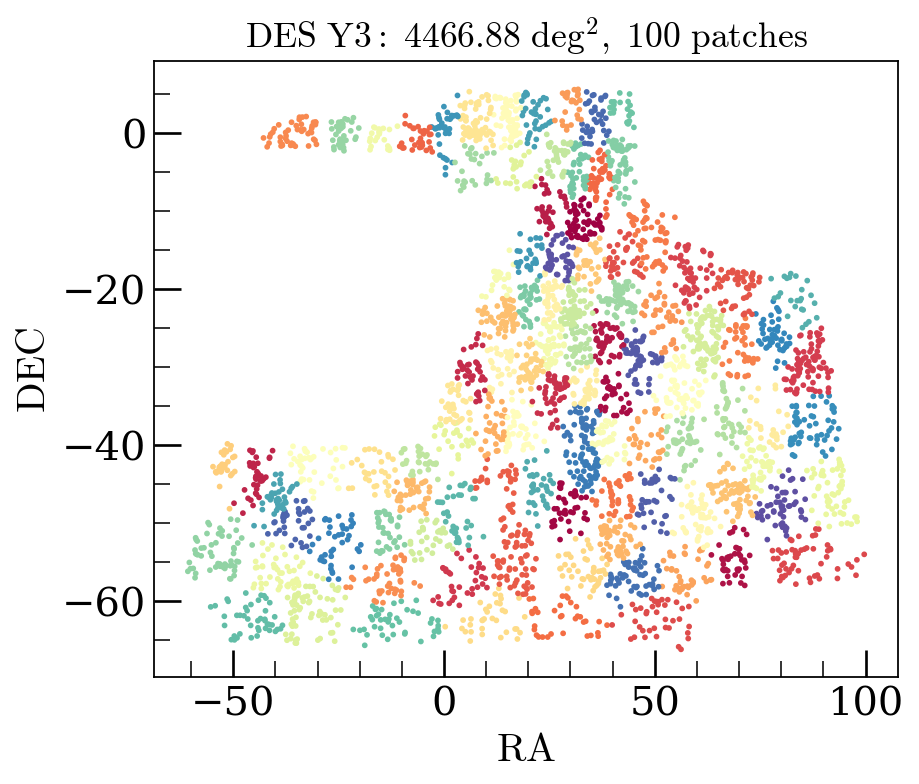

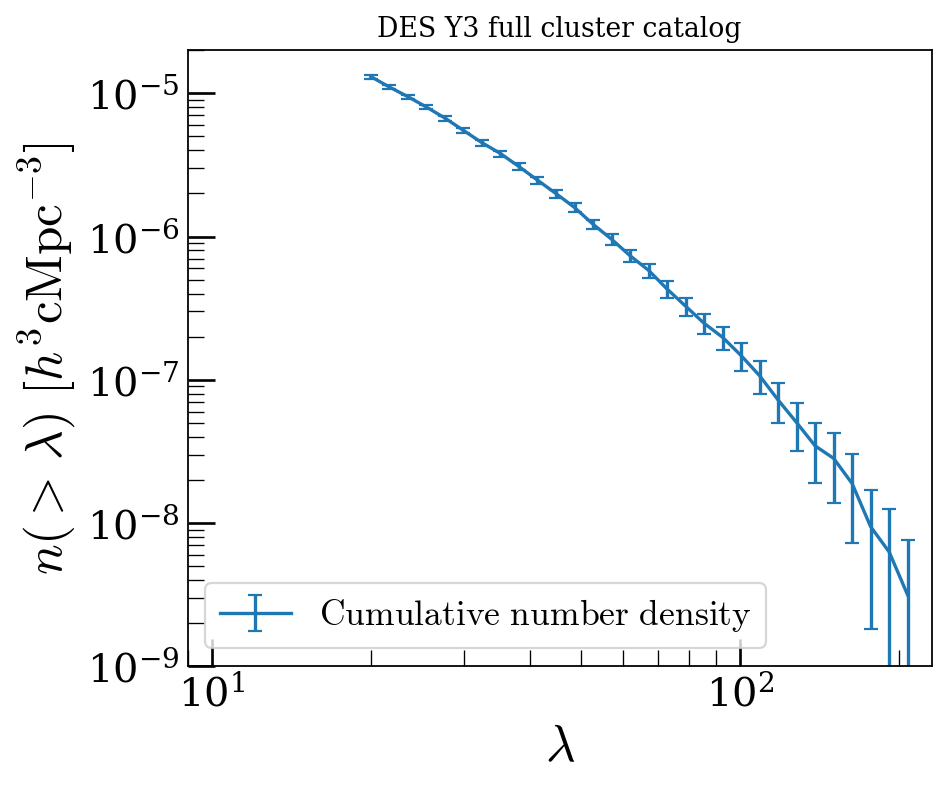

In [2]:
############################################################
######### For DES-Year3 (DESY3) observational data #########
############################################################

DESY3_loc = "/projects/lyang4/projection_effects/cluster_cosmology/DESY3/"
fname = DESY3_loc+'y3_redmapper_v6.4.22+2_release.h5'

f = h5py.File(fname, 'r')
goldcats = f.require_group('/catalog/cluster')


#---------------- for clusters --------------
z_lam   = goldcats['z_lambda'][:]
sel_lam  = (z_lam>=0.2) & (z_lam<=0.35)

ra_desy3      = goldcats['ra'][sel_lam]
dec_desy3     = goldcats['dec'][sel_lam]
lam_desy3     = goldcats['lambda_chisq'][sel_lam]
# lam_err = goldcats['lambda_chisq_e'][sel_lam]

clu_desy3_mem_match_id = goldcats['mem_match_id'][sel_lam]

#---------------- Split clusters into richness bins with z_cuts ----------- 
# Note: richness selection: lam_min <= lambda < lam_max
#       redshift selection: z_min <= redshift <= z_max

lam_bins = [20,30,45,60,np.inf]
nbin_lam = len(lam_bins)-1

DESY3_lam_counts = np.zeros(int(nbin_lam) )

zlam_desy3_min = 0.2
zlam_desy3_max = 0.35

for ib in range(nbin_lam):
    tag = (lam_desy3>=lam_bins[ib])&(lam_desy3<lam_bins[ib+1])  #&(z_lam<=zlam_desy3_max) #&(z_lam>=zlam_desy3_min)
    print(lam_bins[ib], lam_bins[ib+1], 'clu_number', len(lam_desy3[tag]))
    DESY3_lam_counts[ib] = len(lam_desy3[tag])
    

### Assign patches for Jackknife sampling for cumulative number_density error estimation
npatches = 100

region_id_list = assign_jk_labels(ra_desy3, dec_desy3, npatches)
region_id      = region_id_list[0]   # now this is a numpy array
print('JK region:', region_id.shape, 'Total number of used cluster', len(ra_desy3))




#---------------- Calc DESY3 volume ---------------

# nside 512 A_volw (deg^2): 4466.884072703155
# V_eff_total ((Mpc/h)^3): 318493044.449627

desy3_Aeff_deg2  = 4466.8840  #Unit: deg^2 
desy3_Veff_cMpch = 318493044.4496 #Unit: (cMpc/h)^3 



########################################################################################################
N_lambins = 30 ### use for both DESY and Flamingo data

log_min = np.log10(lam_desy3.min())
log_max = np.log10(lam_desy3.max())
thresholds_desy  = np.logspace(log_min, log_max, N_lambins)   


# thresholds = np.linspace(richness.min(), richness.max(), 30)
lam_logbins_desy3 = np.array(thresholds_desy)        # e.g. np.unique(richness)

lam_sorted = np.sort(lam_desy3)
## Check " side='left' " is lam_logbins_desy[i] <= lam_sorted < lam_logbins_desy[i+1]
idx_lam      = np.searchsorted(lam_sorted, lam_logbins_desy3, side='left') 
Nlam_geq     = len(lam_sorted) - idx_lam        # N(>=thr[i])
# ---- 2) Poisson error ----
err_p = np.sqrt(Nlam_geq)


# ---- 3) Jackknife estimate of sample variance ----
regions   = np.unique(region_id)
njk       = len(regions)
counts_jk = np.empty((njk, len(lam_logbins_desy3)))

for i, reg in enumerate(regions):
    # leave-one-region-out sample
    mask       = (region_id != reg)
    r_jk       = np.sort(lam_desy3[mask])
    idx_jk     = np.searchsorted(r_jk, lam_logbins_desy3, side='left')
    counts_jk[i] = len(r_jk) - idx_jk

# jackknife variance (see e.g. https://en.wikipedia.org/wiki/Jackknife_resampling)
mean_jk = counts_jk.mean(axis=0)
var_jk  = (njk - 1) / njk * np.sum((counts_jk - mean_jk)**2, axis=0)
err_s   = np.sqrt(var_jk)

# ---- 4) Total error in quadrature ----
err_tot = np.sqrt(err_p**2 + err_s**2)

numden_desy3_mean = Nlam_geq/desy3_Veff_cMpch
numden_desy3_err  = err_tot/desy3_Veff_cMpch



### --------- A simple plot check: JK sampling ---------

random.seed(423369) # Using 42 as an example seed
colors = cm.Spectral(np.linspace(0, 1, npatches))
np.random.shuffle(colors)

fig = plt.figure(figsize=(6, 5), constrained_layout=False, dpi=160)


tag1 = (ra_desy3>250)
tag2 = (ra_desy3<=250)


plt.scatter(ra_desy3[tag1]-360, dec_desy3[tag1], color=colors[region_id[tag1]],s=2.5)
plt.scatter(ra_desy3[tag2], dec_desy3[tag2], color=colors[region_id[tag2]],s=2.5)

plt.title(rf"$\rm DES~Y3:~{desy3_Aeff_deg2:g}~deg^2,~100~patches$", fontsize=16)

plt.xlabel(r'$\rm RA$', fontsize=18)
plt.ylabel(r'$\rm DEC$', fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=18, length=7, width=.7, direction='in')
plt.tick_params(axis='both', which='major', length=12, width=1.2, direction='in')
plt.minorticks_on()
plt.show()


### --------- A simple plot check: cumulative number density ---------


fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=False, dpi=160)


ax.errorbar(lam_logbins_desy3, 
            numden_desy3_mean, 
            yerr=numden_desy3_err, fmt='-', ms=0, color='#1f77b4', capsize=3,
            label=r"$\rm Cumulative ~number ~density $"
           )




ax.legend(fontsize=16,loc='lower left')
ax.set_xlim(9, 230)
ax.set_ylim(1e-9, 2e-5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$',fontsize=23)
ax.set_ylabel(r'$n(>\,\lambda)~[h^{3}\rm cMpc^{-3}]$',fontsize=23)
ax.set_title('DES Y3 full cluster catalog')
ax.tick_params(axis='both', which='both', labelsize=18, length=7, width=.6, direction='in')
ax.tick_params(axis='both', which='major', length=12, width=1.2, direction='in')
ax.minorticks_on()
plt.show()



# DES Y1

20 30 clu_number 762
30 45 clu_number 376
45 60 clu_number 123
60 inf clu_number 91
JK region: (1352,) Total number of used cluster 1352


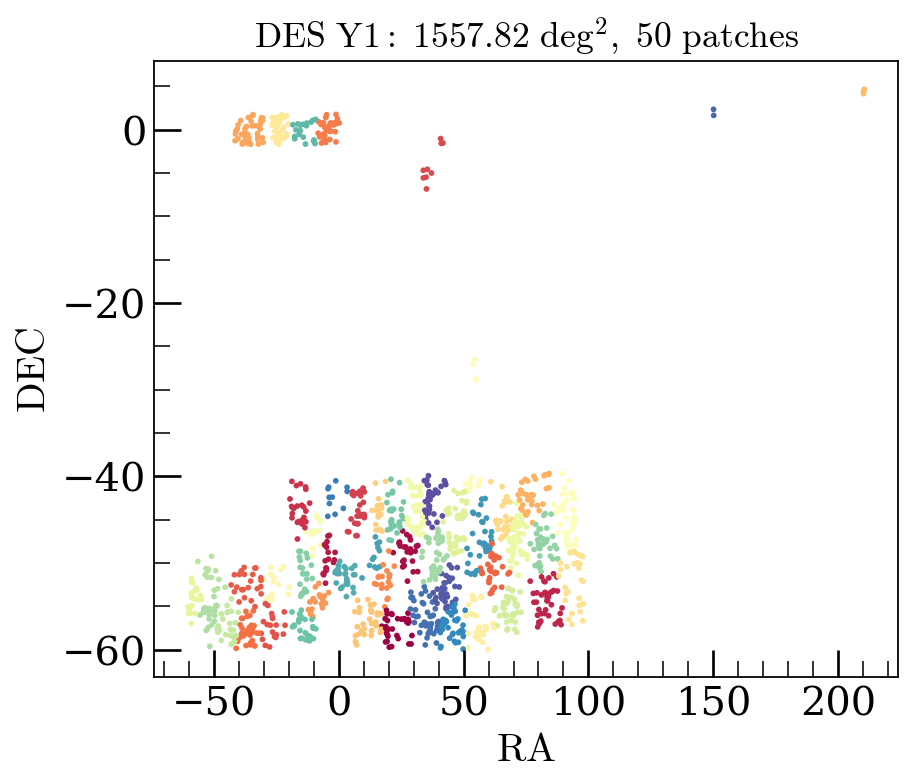

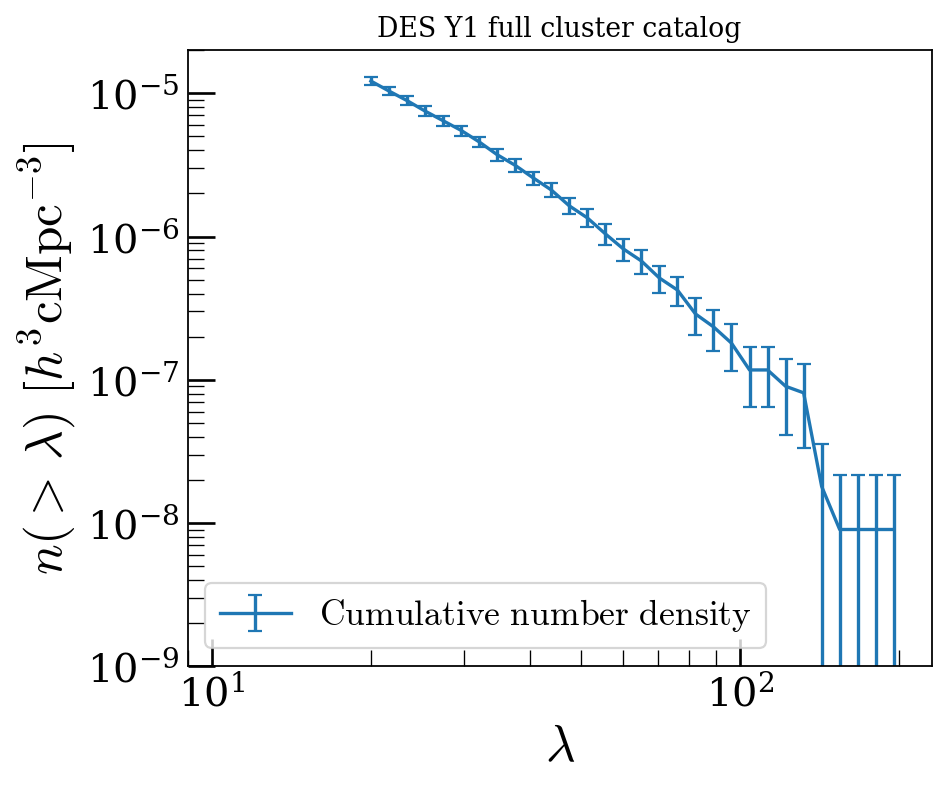

In [3]:
############################################################
######### For DES-Year1 (DESY1) observational data #########
############################################################


fname = DESY3_loc+'des_y1/redmapper_y1a1_public_v6.4_catalog.fits.gz'
with fits.open(fname) as hdul:
    hdul.verify('fix')
    hdata_cluster = hdul[1].data



#---------------- for clusters --------------
z_lam   = hdata_cluster['Z_LAMBDA']
sel_lam  = (z_lam>=0.2) & (z_lam<=0.35)

ra_desy1      = hdata_cluster['RA'][sel_lam]
dec_desy1     = hdata_cluster['DEC'][sel_lam]
lam_desy1     = hdata_cluster['LAMBDA'][sel_lam]


#---------------- Split clusters into richness bins with z_cuts ----------- 
# Note: richness selection: lam_min <= lambda < lam_max
#       redshift selection: z_min <= redshift <= z_max

lam_bins = [20,30,45,60,np.inf]
nbin_lam = len(lam_bins)-1

DESY1_lam_counts = np.zeros(int(nbin_lam) )

zlam_desy1_min = 0.2
zlam_desy1_max = 0.35

for ib in range(nbin_lam):
    tag = (lam_desy1>=lam_bins[ib])&(lam_desy1<lam_bins[ib+1])  
    print(lam_bins[ib], lam_bins[ib+1], 'clu_number', len(lam_desy1[tag]))
    DESY1_lam_counts[ib] = len(lam_desy1[tag])
    

### Assign patches for Jackknife sampling for cumulative number_density error estimation
npatches = 50

region_id_list = assign_jk_labels(ra_desy1, dec_desy1, npatches)
region_id      = region_id_list[0]   # now this is a numpy array
print('JK region:', region_id.shape, 'Total number of used cluster', len(ra_desy1))




#---------------- Calc DESY1 volume ---------------


# nside 4096 A_eff (deg^2): 1557.8232877356809 deg^2 
# V_eff_total ((Mpc/h)^3):111074305.50824429 (Mpc/h)^3

desy1_Aeff_deg2  = 1557.823  #Unit: deg^2 
desy1_Veff_cMpch = 111074305.508 #Unit: (cMpc/h)^3 




########################################################################################################
N_lambins = 30 ### use for both DESY and Flamingo data

log_min = np.log10(lam_desy1.min())
log_max = np.log10(lam_desy1.max())
thresholds_desy  = np.logspace(log_min, log_max, N_lambins)   


# thresholds = np.linspace(richness.min(), richness.max(), 30)
lam_logbins_desy1 = np.array(thresholds_desy)        # e.g. np.unique(richness)

lam_sorted = np.sort(lam_desy1)
## Check " side='left' " is lam_logbins_desy[i] <= lam_sorted < lam_logbins_desy[i+1]
idx_lam      = np.searchsorted(lam_sorted, lam_logbins_desy1, side='left') 
Nlam_geq     = len(lam_sorted) - idx_lam        # N(>=thr[i])
# ---- 2) Poisson error ----
err_p = np.sqrt(Nlam_geq)


# ---- 3) Jackknife estimate of sample variance ----
regions   = np.unique(region_id)
njk       = len(regions)
counts_jk = np.empty((njk, len(lam_logbins_desy1)))

for i, reg in enumerate(regions):
    # leave-one-region-out sample
    mask       = (region_id != reg)
    r_jk       = np.sort(lam_desy1[mask])
    idx_jk     = np.searchsorted(r_jk, lam_logbins_desy1, side='left')
    counts_jk[i] = len(r_jk) - idx_jk

# jackknife variance (see e.g. https://en.wikipedia.org/wiki/Jackknife_resampling)
mean_jk = counts_jk.mean(axis=0)
var_jk  = (njk - 1) / njk * np.sum((counts_jk - mean_jk)**2, axis=0)
err_s   = np.sqrt(var_jk)

# ---- 4) Total error in quadrature ----
err_tot = np.sqrt(err_p**2 + err_s**2)

numden_desy1_mean = Nlam_geq/desy1_Veff_cMpch
numden_desy1_err  = err_tot/desy1_Veff_cMpch



### --------- A simple plot check: JK sampling ---------

random.seed(423369) # Using 42 as an example seed
colors = cm.Spectral(np.linspace(0, 1, npatches))
np.random.shuffle(colors)

fig = plt.figure(figsize=(6, 5), constrained_layout=False, dpi=160)


tag1 = (ra_desy1>250)
tag2 = (ra_desy1<=250)


plt.scatter(ra_desy1[tag1]-360, dec_desy1[tag1], color=colors[region_id[tag1]],s=2.5)
plt.scatter(ra_desy1[tag2], dec_desy1[tag2], color=colors[region_id[tag2]],s=2.5)

plt.title(rf"$\rm DES~Y1:~{desy1_Aeff_deg2:g}~deg^2,~{npatches:g}~patches$", fontsize=16)

plt.xlabel(r'$\rm RA$', fontsize=18)
plt.ylabel(r'$\rm DEC$', fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=18, length=7, width=.7, direction='in')
plt.tick_params(axis='both', which='major', length=12, width=1.2, direction='in')
plt.minorticks_on()
plt.show()


### --------- A simple plot check: cumulative number density ---------


fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=False, dpi=160)


ax.errorbar(lam_logbins_desy1, 
            numden_desy1_mean, 
            yerr=numden_desy1_err, fmt='-', ms=0, color='#1f77b4', capsize=3,
            label=r"$\rm Cumulative ~number ~density $"
           )




ax.legend(fontsize=16,loc='lower left')
ax.set_xlim(9, 230)
ax.set_ylim(1e-9, 2e-5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$',fontsize=23)
ax.set_ylabel(r'$n(>\,\lambda)~[h^{3}\rm cMpc^{-3}]$',fontsize=23)
ax.set_title('DES Y1 full cluster catalog')
ax.tick_params(axis='both', which='both', labelsize=18, length=7, width=.6, direction='in')
ax.tick_params(axis='both', which='major', length=12, width=1.2, direction='in')
ax.minorticks_on()
plt.show()



## Calculate CIC clusters' cumulative number density from FLAMINGO simulation ($z=0.3$)

In [4]:

# --- Paths ---
cat_base = "/projects/lyang4/projection_effects/cluster_cosmology/Flamingo/L1000N3600/HYDRO_FIDUCIAL/z0.3/"
data_m3_path = "/projects/lyang4/projection_effects/cluster_cosmology/Flamingo/L1000N3600/data/data_m3/"
halo_prop_path = (
    "/projects/lyang4/projection_effects/cluster_cosmology/multi_wave/halos/"
    "L1000N3600_HYDRO_FIDUCIAL_halos_m500c_cut_1e13_withID.hdf5"
)



# def main():
# --- Cosmology (Colossus) ---
_ = setup_flamingo_cosmology()

#########################################
######### For FLAMINGO sim data #########
#########################################

# ------ Load halo_id once ------
halo_id = load_halo_id(halo_prop_path)

# --- User parameters ---
Mcut = 1e13 ### Unit: Msun (6.81e12 Msun/h)
gal_dens = ["1.2e-02", "1.0e-02", "8.0e-03", "6.0e-03", "4.0e-03", "2.0e-03", "1.0e-03"]
gal_dens_num = [1.2e-2, 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3]

cyl_depth = [30, 60, 90, 120, 180] ### comoving Mpc/h for count-in-cylinder richness
proj_depth = [60, 90, 180, 300]    ### comoving Mpc/h for r_{\pi} lensing and cy

Mz_cut = [20, 21, 21.5, 22]  ### z-band abs_magnitdue cut  (negligible)
chi2_cut = [6, 8, 10, 50, 100, 150] ### chi2_cut for color (does not matter)

richness_labels = [
    r" [$\rm DESY1~\lambda\in[60, \infty)$]",
    r" [$\rm DESY1~\lambda\in[45, 60)$]",
    r" [$\rm DESY1~\lambda\in[30, 45)$]",
    r" [$\rm DESY1~\lambda\in[20, 30)$]",
]


N_lambins = 30 ### use for both DESY and Flamingo data

### [gal_nd(7), cyl_depth(5), proj_depth(4), Mz_cut(4), chi2_cut(6), N_lambins]
N_cum_lam     = np.zeros((7, 5, 4, 4, 6, N_lambins))
N_cum_lam_err = np.zeros((7, 5, 4, 4, 6, N_lambins))
richness_bins      = np.zeros((7, 5, 4, 4, 6, N_lambins))

# Minimal debug counters
n_missing_file = 0
# n_missing_match = 0
n_loaded = 0

### Loop over all Count-In-Cylinder(CIC) richness cases
for i in range(7): #gal_numdens ['1e-02'...] (cMpc/h)^{-3}
    for j in range(5): # cyl_depth [30...180] cMpc/h
        for k in range(4): # proj_depth for lensing and SZ profile [60...300] cMpc/h
            for mz in range(4): # M_z cut
                for cc in range(6):  # Chi^2 cut
                    model_dir = os.path.join(cat_base, f"model_redmagic_chi{chi2_cut[cc]}_{gal_dens[i]}_HBT")
            
                    file_matchID  = os.path.join(
                        model_dir,
                        f"matched_haloID_M500c_cut{Mcut:.0e}_q{cyl_depth[j]}_Mz_cut-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
                    )
                    file_richness = os.path.join(
                        model_dir,
                        f"richness_q{cyl_depth[j]}_bg_NOmiscen_m500c_Mzmin-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
                    )
            
                    if not os.path.exists(file_richness):
                        n_missing_file += 1
                        # print("[**skip**] richness file missing:", 
                        #       f"richness_q{cyl_depth[j]}_bg_NOmiscen_m500c_Mzmin-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit")
                        continue
            
                    richness, cyl_hm, cyl_hid = load_cylinder_cluster_richness(file_richness)
            
                    # print("Matched halo number:", len(richness))
                    ##------ calc cumulative cluster number with $>=richness_threshold$ ------
                    richness   = np.array(richness)         
                    log_min = np.log10(richness.min())
                    log_max = np.log10(richness.max())
                    
                    # create 50 bins equally spaced in log10
                    thresholds  = np.logspace(log_min, log_max, N_lambins)                    
                    # thresholds = np.linspace(richness.min(), richness.max(), 30)
                    lam_logbins = np.array(thresholds)        # e.g. np.unique(richness)

                    r_sorted = np.sort(richness)
                    # side='left' we have lam_logbins[i] <= r_sorted < lam_logbins[i+1] 
                    idx      = np.searchsorted(r_sorted, lam_logbins, side='left')
                    N_geq     = len(r_sorted) - idx  
                    # ---- 2) Poisson error ----
                    err_p = np.sqrt(N_geq)
                    ##############################
                    N_cum_lam[i, j, k, mz, cc, :]     = N_geq
                    N_cum_lam_err[i, j, k, mz, cc, :] = err_p
                    richness_bins[i, j, k, mz, cc, :] = lam_logbins 
                    # print(N_geq.shape, lam_logbins.shape)
                    n_loaded += 1



print("Loaded cases:", n_loaded)
print("Missing richness files:", n_missing_file)

Loaded cases: 3160
Missing richness files: 200


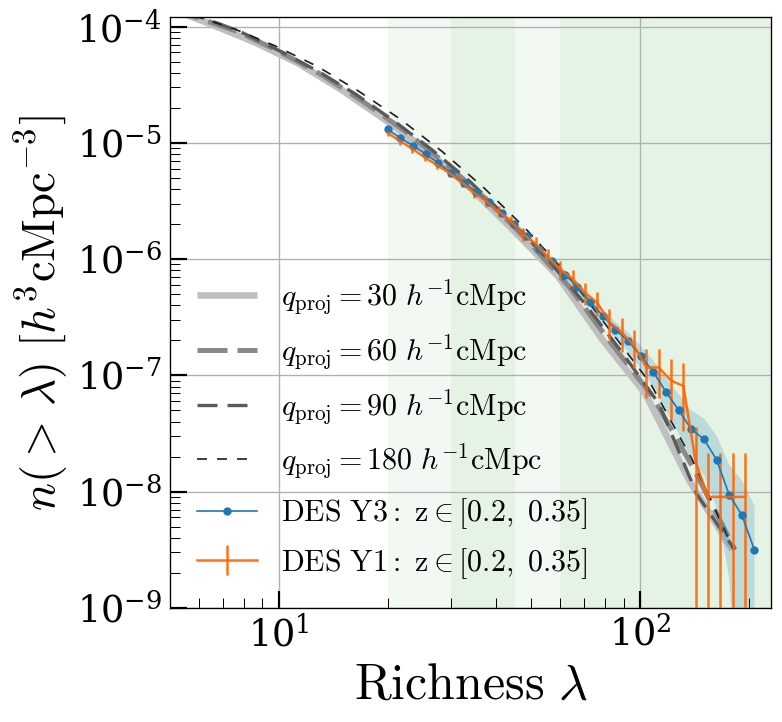

In [5]:

#########################################################################################################################
######### Make final draft plots on comparison of DES Y1Y3 cluster number density and Flamingo cluster catalogs #########
#########################################################################################################################

fig, axs = plt.subplots(1, 1, figsize=(6.5, 6), sharey=True, dpi=120)

richness_color = "#2ca02c"
plt.axvspan(20,30, color=richness_color, alpha=0.06, ec='none')
plt.axvspan(30,45, color=richness_color, alpha=0.12, ec='none')

plt.axvspan(45,60, color=richness_color, alpha=0.06, ec='none')
plt.axvspan(60,300, color=richness_color, alpha=0.12, ec='none')

# plt.axvline(x=30, color=richness_color, linestyle='-', linewidth=1.5)
# plt.axvline(x=45, color=richness_color, linestyle='-', linewidth=1.5)
# plt.axvline(x=60, color=richness_color, linestyle='-', linewidth=1.5)


# Vbox      = (1000*h)**3
h=0.681
Vbox = (1000*h)**3

colors = cm.Greys_r(np.linspace(0.1, 0.9, 10))
jcls = [6,4,2,1,0] 

k  = 0 ### for lensing, ignore
mz = 2 ### M_z cut = [20, 21, 21.5, 22]  ### 4
cc = 0 ### chi^2 cut = [6, 10, 20, 50, 100, 150]
# for i in range(1,2,1): #i = 1 # Set gal_dens ['1e-02'] and gal_dens_num
i = 1
lws=[4,3,2,2,1]
dash_styles = [(6,0), (6,2), (6,3), (5,3), (6,6)]

j_cyldepth = [0, 1, 2, 4]
for j in j_cyldepth: #range(5): # Set cyl_depth
    axs.plot(richness_bins[i, j, k, mz, cc, :],
             N_cum_lam[i, j, k, mz, cc, :]/Vbox, #mean_corrcoef_lamDS[:, q, k, mz, cc, g],
             #yerr = None, #N_cum_lam_err[j, k, mz, cc, i, :]/Vbox, #std_cc_DScy_rps[:,im],
             '--',dashes=dash_styles[j], lw=lws[j], alpha=1, #lw=lws[g],
             color=colors[jcls[j]], #elinewidth=2, capsize=0,capthick=1, color=colors[jcls[j]],  #,'#9467bd'
             label = f"$q_{{\\rm proj}} = {cyl_depth[j]:g}$"+r"$~h^{-1}\rm cMpc$")


axs.errorbar(lam_logbins_desy3, 
             numden_desy3_mean, 
             yerr=None, fmt='-o', ms=4, color='#1f77b4', capsize=3, lw=1, # #ff7f0e
             label=r"$\rm DES~Y3:~z\in[0.2,~0.35]$",zorder=5
            )

axs.fill_between(lam_logbins_desy3, 
                 numden_desy3_mean-numden_desy3_err, 
                 numden_desy3_mean+numden_desy3_err,
                 linewidth=2, alpha=0.2, edgecolor=None, facecolor='#1f77b4',
                 zorder=4
                ) # #ff7f0e


axs.errorbar(lam_logbins_desy1, 
             numden_desy1_mean, 
             yerr=numden_desy1_err, fmt='-', ms=0, color='#FF6500', capsize=0, alpha=0.9,
             label=r"$\rm DES~Y1:~z\in[0.2,~0.35]$",zorder=5
            )



axs.set_xlim(5, 230)
axs.set_ylim(1e-9, 1.2e-4)

axs.set_xscale('log')
axs.set_yscale('log')

axs.tick_params(axis='both', which='both', labelsize=22, length=6, width=.6, direction='in')
axs.tick_params(axis='both', which='major', length=10, width=1.3, direction='in')
axs.tick_params(axis='x', pad=5)
axs.tick_params(axis='y', pad=5)

# axs.yaxis.set_minor_locator(tck.AutoMinorLocator())
axs.grid(True)
axs.minorticks_on()

axs.set_xlabel(r'$\rm Richness~\lambda$',fontsize=30)
axs.set_ylabel(r'$n(>\,\lambda)~[h^{3}\rm cMpc^{-3}]$',fontsize=28)

plt.legend(fontsize=18,handlelength=2.0, frameon=False)#,loc=[0.02,2e-9])
# handles, labels = axs.get_legend_handles_labels()


plt.tight_layout()
fig.subplots_adjust(left=0.21, bottom=0.16, right=0.98, top=0.98)


# fig.savefig(f'Cnumdens_4lamnins_DES_Y1Y3_Flamingo.png', dpi=160)#dpi=fig.dpi)

plt.show()


# Top-ranked richness from DES Y1/Y3 to CIC clusters in FlAMINGO

In [7]:
# Expected richness in FLAMINGO box by volume scaling
scale_desy1 = Vbox/desy1_Veff_cMpch
scale_desy3 = Vbox/desy3_Veff_cMpch

lam_DES_Y1 = DESY1_lam_counts * scale_desy1
lam_DES_Y3 = DESY3_lam_counts * scale_desy3

print("Scaled richness in FLAMINGO box:")
print("  DES Y1:  ", lam_DES_Y1, "rounded:", np.round(lam_DES_Y1).astype(int))
print("  DES Y3:  ", lam_DES_Y3, "rounded:", np.round(lam_DES_Y3).astype(int))

Scaled richness in FLAMINGO box:
  DES Y1:   [2166.6197645  1069.09321713  349.72996199  258.74330521] rounded: [2167 1069  350  259]
  DES Y3:   [2395.73243923 1102.67155315  369.87094364  256.82727722] rounded: [2396 1103  370  257]
